In [1]:
import networkx as nx
import os
from pathlib import Path
import pandas as pd
import numpy as np
import math
from scipy.stats import linregress, zscore
import re  # added: needed by clean_str

In [8]:
# setup

xferpath = Path(r"C:\Users\User\Documents\cfb project\data\transferportal\cleaned")
recpath = Path(r"C:\Users\User\Documents\cfb project\data\recruiting")
xferfiles = {}
recfiles = {}

for file_path in xferpath.glob('*_cleaned.graphml'):
    name = file_path.stem.replace('_cleaned', '')
    G_x = nx.read_graphml(file_path)
    xferfiles[name] = G_x

for file_path in recpath.glob('*.graphml'):
    name = file_path.stem
    G_r = nx.read_graphml(file_path)
    recfiles[name] = G_r

nd_npv_ppa_df = pd.read_csv(r'C:\Users\User\Documents\cfb project\data\analysis\nd_npv\degree_analysis_ppa.csv')
nd_npv_df = pd.read_csv(r'C:\Users\User\Documents\cfb project\data\analysis\nd_npv\degree_analysis_rating.csv')
#rvi_gvo_df = pd.read_csv(r'')
teamratings_df = pd.read_csv(r'C:\Users\User\Documents\cfb project\data\supplemental\team_performance.csv')
playerratings_df = pd.read_csv(r'C:\Users\User\Documents\cfb project\data\supplemental\player_performance.csv', encoding='latin1')
rosters_df = pd.read_csv(r'C:\Users\User\Documents\cfb project\data\supplemental\rosters.csv', dtype={5: str})

print(f"\nSuccessfully loaded {len(xferfiles)} files from xfer, {len(recfiles)} files from rec, and supplemental data")



Successfully loaded 5 files from xfer, 27 files from rec, and supplemental data


In [ ]:
# ND/NPV

# ============================================
# 2. DEFINE CALCULATION LOGIC
# ============================================

def nd_npv_rating(G):
    """
    Calculate NPV for each school based on summing individual player ratings.
    Includes uncertainty bounds for missing data.
    """
    school_stats = {}
    
    for node in G.nodes():

        in_transfers = []
        out_transfers = []
        in_missing = 0
        out_missing = 0
        
        # Incoming transfers (Predecessors -> Node)
        for pred in G.predecessors(node):
            for key, data in G[pred][node].items():
                rating = data.get('ratings', '')
                try:
                    # Check if rating is a valid number
                    if rating and str(rating) not in ['', '0.0', 'None', 'nan']:
                        in_transfers.append(float(rating))
                    else:
                        in_missing += 1
                except ValueError:
                    in_missing += 1
        
        # Outgoing transfers (Node -> Successors)
        for succ in G.successors(node):
            for key, data in G[node][succ].items():
                rating = data.get('ratings', '')
                try:
                    if rating and str(rating) not in ['', '0.0', 'None', 'nan']:
                        out_transfers.append(float(rating))
                    else:
                        out_missing += 1
                except ValueError:
                    out_missing += 1
        
        # Calculate sums (The "Raw" Values)
        in_sum = sum(in_transfers)
        out_sum = sum(out_transfers)
        npv = in_sum - out_sum
        
        # Calculate uncertainty bounds
        # Best case: Missing Incoming are 5-stars (0.99), Missing Outgoing are 3-stars (0.75)
        # Worst case: Missing Incoming are 3-stars (0.75), Missing Outgoing are 5-stars (0.99)
        best_case_npv = (in_sum + in_missing * 0.95) - (out_sum + out_missing * 0.75)
        worst_case_npv = (in_sum + in_missing * 0.75) - (out_sum + out_missing * 0.95)
        
        # Assumed NPV is the midpoint
        assumed_npv = (best_case_npv + worst_case_npv) / 2
        
        # If no missing data, assumed is just raw npv
        if (in_missing + out_missing) == 0:
            assumed_npv = npv
            
        uncertainty = (best_case_npv - worst_case_npv) / 2
        
        school_stats[node] = {
            'NPV_raw': round(npv, 2),
            'NPV_assumed': round(assumed_npv, 2),
            'in_wt': round(in_sum, 2),
            'out_wt': round(out_sum, 2),
            'net_degree': len(in_transfers) - len(out_transfers),
            'in_count': len(in_transfers),
            'out_count': len(out_transfers),
            'in_missing': in_missing,
            'out_missing': out_missing,
            'missing': in_missing + out_missing,
            'uncertainty': round(uncertainty, 2),
            'NPV_high': round(best_case_npv, 2),
            'NPV_low': round(worst_case_npv, 2)
        }
    
    return school_stats

# ============================================
# 3. EXECUTE AND BUILD DATAFRAME
# ============================================

all_npv_records = []

print("Processing files...")

for filename, G in xferfiles.items():
    # Extract Year from filename (looks for 4 consecutive digits)
    year_match = re.search(r'(\d{4})', filename)
    if year_match:
        year = int(year_match.group(1))
        
        # Calculate stats for this year
        stats = nd_npv_rating(G)
        
        # Flatten into list of dicts
        for school, data in stats.items():
            record = data.copy()
            record['school'] = school
            record['year'] = year
            all_npv_records.append(record)
    else:
        print(f"  Warning: Could not extract year from {filename}")

# Create DataFrame
npv_df = pd.DataFrame(all_npv_records)

# ============================================
# 4. CALCULATE STANDARDIZED METRICS
# ============================================

if not npv_df.empty:
    # Standardize School Names
    npv_df['school'] = npv_df['school'].astype(str).str.strip()
    
    # Calculate Z-Scores (Team Level)
    # This standardizes the "Assumed NPV" relative to other teams in that specific year
    npv_df['NPV_zscore'] = npv_df.groupby('year')['NPV_assumed'].transform(
        lambda x: zscore(x, nan_policy='omit')
    )
    
    # Calculate Percentiles
    npv_df['NPV_percentile'] = npv_df.groupby('year')['NPV_assumed'].rank(pct=True) * 100
    
    # Round to 2 decimal places
    npv_df['NPV_zscore'] = npv_df['NPV_zscore'].round(2)
    npv_df['NPV_percentile'] = npv_df['NPV_percentile'].round(2)

    # Reorder columns: Keys first, then metrics
    cols = ['year', 'school', 'NPV_zscore', 'NPV_percentile', 'NPV_raw', 'NPV_assumed', 
            'net_degree', 'in_count', 'out_count', 
            'in_wt', 'out_wt', 'uncertainty', 'NPV_high', 'NPV_low',
            'missing', 'in_missing', 'out_missing']
            
    # Keep only columns that exist (in case no missing data found)
    cols = [c for c in cols if c in npv_df.columns]
    npv_df = npv_df[cols]

    print(f"\nSuccessfully created npv_df with {len(npv_df)} records.")
    print(f"Years covered: {sorted(npv_df['year'].unique())}")
    print("\nSample Data (first 5 rows):")
    print(npv_df[['year', 'school', 'NPV_zscore', 'NPV_raw', 'NPV_assumed']].head().to_string())
else:
    print("Error: No data records generated.")

Processing files...

Successfully created npv_df with 1591 records.
Years covered: [np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]

Sample Data (first 5 rows):
   year          school  NPV_zscore  NPV_raw  NPV_assumed
0  2021        Missouri       -2.48    -9.34        -9.34
1  2021            UTSA        1.55     5.00         5.85
2  2021  Arkansas State        2.70    10.18        10.18
3  2021   Southern Miss        0.47     1.76         1.76
4  2021           Miami       -0.23    -0.85        -0.85


In [ ]:
# master df with all metrics

# ============================================
# COMPREHENSIVE TALENT METRICS CALCULATION
# RVI, GVO, NPV, TD, PCR (2000-2025)
# ============================================

print("="*70)
print("CALCULATING COMPREHENSIVE TALENT METRICS")
print("="*70)

# ============================================
# STEP 1: ROBUST RECRUITING DATA EXTRACTION
# ============================================

print("\nStep 1: Processing recruiting data (Bidirectional Check)...")

all_recruits = []

for year in range(2000, 2026):  # 2000-2025
    graph_name = f"recruiting_network_{year}"
    
    if graph_name not in recfiles:
        print(f"  Warning: {graph_name} not found, skipping...")
        continue
    
    G = recfiles[graph_name]
    count_for_year = 0
    
    # Iterate through all edges
    for u, v, key, data in G.edges(data=True, keys=True):
        
        # LOGIC FIX: Determine which node is the school
        # We check both the source (u) and target (v) for the 'type' attribute
        school_node = None
        
        # Check if Target (v) is the school (Standard case)
        if G.nodes[v].get('type') == 'School':
            school_node = v
            
        # Check if Source (u) is the school (Inverted case)
        elif G.nodes[u].get('type') == 'School':
            school_node = u
            
        # If we found a school node, process the recruit
        if school_node:
            recruit_id = data.get('id', None)
            athlete_id = data.get('athlete_id', None)
            player_name = data.get('player', None)
            rating = data.get('rating', None)
            stars = data.get('stars', None)
            position = data.get('position', None)
            
            # Data cleaning: Ensure rating is valid
            if rating is not None:
                try:
                    rating_val = float(rating)
                    if rating_val > 0:
                        all_recruits.append({
                            'year': year,
                            'school': school_node,
                            'player_name': player_name,
                            'recruit_id': recruit_id,
                            'athlete_id': athlete_id,
                            'rating': rating_val,
                            'stars': int(stars) if stars else None,
                            'position': position
                        })
                        count_for_year += 1
                except (ValueError, TypeError):
                    continue

    print(f"  {year}: Found {count_for_year} recruits")

df_recruits = pd.DataFrame(all_recruits)

# Standardize school names immediately
if not df_recruits.empty:
    df_recruits['school'] = df_recruits['school'].astype(str).str.strip()
    
    print(f"\nTotal recruit records collected: {len(df_recruits)}")
    
    # DIAGNOSTIC: Check specific problematic schools
    print("\nDiagnostic Check (Average recruits per year for key teams):")
    for team in ['LSU', 'Alabama', 'Georgia', 'Texas A&M']:
        team_data = df_recruits[df_recruits['school'] == team]
        avg_count = len(team_data) / len(df_recruits['year'].unique())
        print(f"  {team}: {len(team_data)} total ({avg_count:.1f} per year)")
    
    # Calculate percentile rankings within each year
    print("\n  Calculating percentile rankings within each year...")
    df_recruits['rating_percentile'] = df_recruits.groupby('year')['rating'].rank(pct=True) * 100
    df_recruits['rating_zscore'] = df_recruits.groupby('year')['rating'].transform(lambda x: zscore(x, nan_policy='omit'))

else:
    print("\nCRITICAL ERROR: No recruits found! Check graph node attributes.")

# ============================================
# STEP 2: BUILD PLAYER TRACKING DICTIONARY
# ============================================

print("\nStep 2: Building player tracking system...")

# Create lookup: player_id -> {recruit_year, school, rating, percentile, zscore}
player_recruit_info = {}

for _, row in df_recruits.iterrows():
    athlete_id = str(row['athlete_id']) if pd.notna(row['athlete_id']) else None
    
    if athlete_id and athlete_id != 'Unknown':
        player_recruit_info[athlete_id] = {
            'recruit_year': row['year'],
            'recruit_school': row['school'],
            'rating': row['rating'],
            'rating_percentile': row['rating_percentile'],
            'rating_zscore': row['rating_zscore'],
            'player_name': row['player_name']
        }

print(f"  Tracked {len(player_recruit_info)} unique players with recruit IDs")

# ============================================
# STEP 3: IDENTIFY GRADUATING PLAYERS (GVO)
# ============================================

print("\nStep 3: Identifying graduating players...")

# Clean roster data
rosters_df['player_id'] = rosters_df['player_id'].astype(str)
rosters_df['year'] = rosters_df['year'].astype(int)

# For each year, find players who were on roster but not next year
graduating_players = []

for year in range(2000, 2025):  # Can't calculate GVO for 2025 (no 2026 data)
    current_year_roster = rosters_df[rosters_df['year'] == year]
    next_year_roster = rosters_df[rosters_df['year'] == year + 1]
    
    # Get all player_ids in next year (any team)
    next_year_player_ids = set(next_year_roster['player_id'].unique())
    
    # Find players who left
    for _, player in current_year_roster.iterrows():
        player_id = player['player_id']
        
        if player_id not in next_year_player_ids:
            # Player graduated/left
            # Try to link to recruiting info
            recruit_info = player_recruit_info.get(str(player_id), None)
            
            graduating_players.append({
                'grad_year': year,
                'school': player['team'],
                'player_id': player_id,
                'player_name': player['name'],
                'recruit_year': recruit_info['recruit_year'] if recruit_info else None,
                'rating': recruit_info['rating'] if recruit_info else None,
                'rating_percentile': recruit_info['rating_percentile'] if recruit_info else None,
                'rating_zscore': recruit_info['rating_zscore'] if recruit_info else None
            })

df_graduating = pd.DataFrame(graduating_players)
print(f"  Identified {len(df_graduating)} graduating players")
print(f"  Linked to recruiting data: {df_graduating['rating'].notna().sum()} ({df_graduating['rating'].notna().sum()/len(df_graduating)*100:.1f}%)")

# ============================================
# STEP 4: CALCULATE RVI (RECRUITING VALUE IN)
# ============================================

print("\nStep 4: Calculating RVI...")

rvi_by_school_year = df_recruits.groupby(['year', 'school']).agg({
    'rating_zscore': 'sum',
    'rating_percentile': 'sum',
    'rating': 'sum',
    'recruit_id': 'count'
}).rename(columns={
    'rating_zscore': 'RVI_zscore',
    'rating_percentile': 'RVI_percentile',
    'rating': 'RVI_raw',
    'recruit_id': 'RVI_count'
}).reset_index()

print(f"  Calculated RVI for {len(rvi_by_school_year)} school-year combinations")

# ============================================
# STEP 5: CALCULATE GVO (GRADUATING VALUE OUT)
# ============================================

print("\nStep 5: Calculating GVO...")

# Only use players we have rating data for
df_graduating_rated = df_graduating[df_graduating['rating'].notna()]

gvo_by_school_year = df_graduating_rated.groupby(['grad_year', 'school']).agg({
    'rating_zscore': 'sum',
    'rating_percentile': 'sum',
    'rating': 'sum',
    'player_id': 'count'
}).rename(columns={
    'rating_zscore': 'GVO_zscore',
    'rating_percentile': 'GVO_percentile',
    'rating': 'GVO_raw',
    'player_id': 'GVO_count'
}).reset_index().rename(columns={'grad_year': 'year'})

print(f"  Calculated GVO for {len(gvo_by_school_year)} school-year combinations")

# Also calculate total graduating count (including unrated players)
gvo_total_count = df_graduating.groupby(['grad_year', 'school']).size().reset_index(name='GVO_total_count').rename(columns={'grad_year': 'year'})

# ============================================
# DIAGNOSTIC CODE AFTER STEP 5 (FIXED)
# ============================================

print("\n" + "="*70)
print("DIAGNOSTIC: GVO Data Quality Check")
print("="*70)

# Check 2024 specifically
print("\n2024 GVO Analysis:")
gvo_2024 = df_graduating[df_graduating['grad_year'] == 2024]
print(f"  Total graduating players in 2024: {len(gvo_2024)}")
print(f"  Players with rating data: {gvo_2024['rating'].notna().sum()}")
print(f"  Players with player_id: {gvo_2024['player_id'].notna().sum()}")  # FIXED: changed recruit_id to player_id

if len(gvo_2024[gvo_2024['rating'].notna()]) > 0:
    print("\nSample of 2024 graduates WITH rating data:")
    print(gvo_2024[gvo_2024['rating'].notna()][['school', 'player_name', 'recruit_year', 'rating', 'rating_zscore']].head(10))
else:
    print("\n⚠ NO graduates in 2024 have rating data!")
    print("\nSample of graduates WITHOUT rating data:")
    print(gvo_2024[['school', 'player_name', 'player_id']].head(10))

# Check if GVO merge worked
gvo_2024_agg = gvo_by_school_year[gvo_by_school_year['year'] == 2024]
print(f"\n2024 GVO aggregated records: {len(gvo_2024_agg)}")
if len(gvo_2024_agg) > 0:
    print("Sample schools with GVO data:")
    print(gvo_2024_agg[['school', 'GVO_zscore', 'GVO_count']].head(10))
else:
    print("⚠ NO aggregated GVO data for 2024!")

# Check the player_recruit_info linkage quality
print(f"\nPlayer linkage statistics:")
print(f"  Total players in player_recruit_info: {len(player_recruit_info)}")
sample_roster_2024 = rosters_df[rosters_df['year'] == 2024]['player_id'].head(10).tolist()
print(f"  Sample 2024 roster player_ids: {sample_roster_2024}")
matches = sum(1 for pid in sample_roster_2024 if str(pid) in player_recruit_info)
print(f"  How many of these 10 are in player_recruit_info: {matches}")

# ============================================
# STEP 6: PROCESS NPV DATA (FROM EXISTING DATAFRAME)
# ============================================

print("\nStep 6: Processing NPV data from nd_npv_ratings_df...")

# Check if the dataframe exists in memory
if 'nd_npv_ratings_df' in locals():
    # Create a copy to avoid SettingWithCopy warnings on the original
    npv_data = nd_npv_ratings_df.copy()
    
    # 1. EXTRACT YEAR FROM FILENAME
    # Looks for 4 digits in a row (e.g., 2023 from "degree_analysis_2023.csv")
    print("  Extracting years from filenames...")
    npv_data['year'] = npv_data['File'].astype(str).str.extract(r'(\d{4})').astype(int)
    
    # 2. STANDARDIZE COLUMN NAMES
    # Map the columns shown in your screenshot to the metrics format
    # Note: Ensure there is a 'school' or 'team' column in nd_npv_ratings_df
    
    # specific fix if school column is named 'team'
    if 'team' in npv_data.columns and 'school' not in npv_data.columns:
        npv_data = npv_data.rename(columns={'team': 'school'})
        
    col_map = {
        'npv': 'NPV_raw',
        'assumed_npv': 'NPV_assumed',
        'in_wt': 'NPV_in_wt',
        'out_wt': 'NPV_out_wt',
        'net_degree': 'NPV_net_count',
        'in_count': 'NPV_in_count',
        'out_count': 'NPV_out_count',
        'total_missing': 'NPV_missing',
        'uncertainty': 'NPV_uncertainty', 
        'in_missing': 'NPV_in_missing', # Added based on your screenshot
        'out_missing': 'NPV_out_missing' # Added based on your screenshot
    }
    
    npv_data = npv_data.rename(columns=col_map)
    
    # 3. CALCULATE METRICS
    print("  Calculating NPV z-scores and percentiles...")
    
    # Calculate NPV z-scores within each year
    npv_data['NPV_zscore'] = npv_data.groupby('year')['NPV_assumed'].transform(
        lambda x: zscore(x, nan_policy='omit')
    )
    
    # Calculate percentile version
    npv_data['NPV_percentile'] = npv_data.groupby('year')['NPV_assumed'].rank(pct=True) * 100
    
    # 4. SELECT FINAL COLUMNS
    # Keep school, year, and all NPV_ columns
    cols_to_keep = ['year', 'school'] + [c for c in npv_data.columns if c.startswith('NPV_')]
    
    # Filter to only keep columns that actually exist
    cols_to_keep = [c for c in cols_to_keep if c in npv_data.columns]
    npv_data = npv_data[cols_to_keep]
    
    print(f"  Processed NPV data for {len(npv_data)} school-year combinations")
    print(f"  Years covered: {sorted(npv_data['year'].unique())}")
    
    # Diagnostic print
    print("\n  Sample processed NPV data:")
    print(npv_data[['year', 'school', 'NPV_assumed', 'NPV_zscore']].head())

else:
    print("  CRITICAL ERROR: 'nd_npv_ratings_df' not found in environment!")
    # Create empty structure to prevent crashes in Step 7
    npv_data = pd.DataFrame(columns=['year', 'school', 'NPV_zscore', 'NPV_assumed'])

# ============================================
# ALSO ADD DIAGNOSTIC AFTER STEP 6 (NPV)
# ============================================

print("\n" + "="*70)
print("DIAGNOSTIC: NPV Data Quality Check")
print("="*70)

if 'npv_data' in locals() and len(npv_data) > 0:
    npv_2024 = npv_data[npv_data['year'] == 2024]
    print(f"\n2024 NPV records: {len(npv_2024)}")
    if len(npv_2024) > 0:
        print("Sample 2024 NPV data:")
        print(npv_2024[['school', 'NPV_assumed', 'NPV_zscore']].head(10))
    else:
        print("⚠ No NPV data found for 2024!")
else:
    print("⚠ NPV data not loaded or empty!")

# ============================================
# STEP 7: ROBUST MERGE (UNION OF ALL SOURCES)
# ============================================

print("\nStep 7: Merging all metrics (Robust Method)...")

# 1. Standardize School Names (Optional but recommended)
#    Ensure 'school' column exists and is string type in all dfs
for df_temp in [df_recruits, gvo_by_school_year, npv_data]:
    if 'school' in df_temp.columns:
        df_temp['school'] = df_temp['school'].astype(str).str.strip()

# 2. Build the Master Spine
#    Collect every unique (Year, School) pair from ALL sources
print("  Building master index of schools/years...")
sources = [
    df_recruits[['year', 'school']], 
    gvo_by_school_year[['year', 'school']],
    npv_data[['year', 'school']]
]

all_school_years = pd.concat(sources, ignore_index=True).drop_duplicates().sort_values(['year', 'school'])

print(f"  Master Index created: {len(all_school_years)} unique school-year combinations")

# 3. Perform Merges (Left Merge onto the Master Spine)
#    Now if a school exists in ANY list, it stays in the final file.
merged = all_school_years.merge(rvi_by_school_year, on=['year', 'school'], how='left')
merged = merged.merge(gvo_by_school_year, on=['year', 'school'], how='left')
merged = merged.merge(gvo_total_count, on=['year', 'school'], how='left')
merged = merged.merge(npv_data, on=['year', 'school'], how='left')

# 4. Fill NaNs with 0 for metrics (but keep NaN for IDs/Strings if any)
#    We only fill specific numeric metric columns
metric_cols = [
    'RVI_zscore', 'RVI_percentile', 'RVI_raw', 'RVI_count',
    'GVO_zscore', 'GVO_percentile', 'GVO_raw', 'GVO_count', 'GVO_total_count'
]
# Note: For NPV, we might want to leave NaNs for years < 2021, 
# but for valid years, 0 is safer for calculation. 
# For now, we fill 0 to allow TD/PCR calculation.
merged[metric_cols] = merged[metric_cols].fillna(0)

print(f"  Merged data shape: {merged.shape}")

# DIAGNOSTIC: Check for the specific teams you mentioned
check_teams = ['LSU', 'Texas A&M', 'Louisiana State']
print("\n  Diagnostic Check for missing teams (2020-2024):")
for team in check_teams:
    team_data = merged[(merged['school'] == team) & (merged['year'] >= 2020)]
    if len(team_data) > 0:
        print(f"  ✓ Found {team}: {len(team_data)} years present")
        # Show which data sources populated
        sample = team_data.iloc[0]
        print(f"    Sample ({sample['year']}): RVI={sample['RVI_raw']:.1f}, NPV={sample['NPV_assumed']:.1f}")
    else:
        print(f"  ⚠ {team} NOT FOUND in Master Index")

# ============================================
# STEP 8: CALCULATE COMPOSITE METRICS (MODIFIED)
# ============================================

print("\nStep 8: Calculating TD and PCR...")

# Talent Delta (TD) = RVI + NPV - GVO
# For years without NPV (pre-2021), NPV will be NaN - handle this
merged['TD_zscore'] = merged['RVI_zscore'] + merged['NPV_zscore'].fillna(0) - merged['GVO_zscore']
merged['TD_percentile'] = merged['RVI_percentile'] + merged['NPV_percentile'].fillna(0) - merged['GVO_percentile']
merged['TD_raw'] = merged['RVI_raw'] + merged['NPV_assumed'].fillna(0) - merged['GVO_raw']
merged['TD_count'] = merged['RVI_count'] + merged['NPV_net_count'].fillna(0) - merged['GVO_count']

# Portal Contribution Ratio (PCR) = NPV / RVI
# Only calculate for years with NPV data (2021+)
merged['PCR_zscore'] = np.where(
    (merged['RVI_zscore'] != 0) & (merged['NPV_zscore'].notna()),
    merged['NPV_zscore'] / merged['RVI_zscore'],
    np.nan  # Use NaN instead of 0 for years without portal
)

merged['PCR_percentile'] = np.where(
    (merged['RVI_percentile'] != 0) & (merged['NPV_percentile'].notna()),
    merged['NPV_percentile'] / merged['RVI_percentile'],
    np.nan
)

merged['PCR_raw'] = np.where(
    (merged['RVI_raw'] != 0) & (merged['NPV_assumed'].notna()),
    merged['NPV_assumed'] / merged['RVI_raw'],
    np.nan
)

merged['PCR_count'] = np.where(
    (merged['RVI_count'] != 0) & (merged['NPV_net_count'].notna()),
    merged['NPV_net_count'] / merged['RVI_count'],
    np.nan
)

# ============================================
# STEP 9: CALCULATE ROSTER CHURN
# ============================================

print("\nStep 9: Calculating roster churn...")

# Roster churn = (new players) / (total roster size)
# New players = RVI_count + NPV_in_count

roster_sizes = rosters_df.groupby(['year', 'team']).size().reset_index(name='roster_size')
roster_sizes = roster_sizes.rename(columns={'team': 'school'})

merged = merged.merge(roster_sizes, on=['year', 'school'], how='left')

merged['new_players'] = merged['RVI_count'] + merged['NPV_in_count']
merged['roster_churn_pct'] = np.where(
    merged['roster_size'] > 0,
    (merged['new_players'] / merged['roster_size']) * 100,
    0
)

# ============================================
# STEP 10: REORDER COLUMNS AND SAVE
# ============================================

print("\nStep 10: Finalizing output...")

# Reorder columns for readability
column_order = [
    'year', 'school',
    
    # RVI metrics
    'RVI_zscore', 'RVI_percentile', 'RVI_raw', 'RVI_count',
    
    # GVO metrics
    'GVO_zscore', 'GVO_percentile', 'GVO_raw', 'GVO_count', 'GVO_total_count',
    
    # NPV metrics (2021+ only)
    'NPV_zscore', 'NPV_percentile', 'NPV_assumed', 'NPV_raw',
    'NPV_net_count', 'NPV_in_count', 'NPV_out_count',
    'NPV_in_wt', 'NPV_out_wt',
    'NPV_uncertainty', 'NPV_high', 'NPV_low', 'NPV_missing',
    
    # Composite metrics
    'TD_zscore', 'TD_percentile', 'TD_raw', 'TD_count',
    'PCR_zscore', 'PCR_percentile', 'PCR_raw', 'PCR_count',
    
    # Roster metrics
    'roster_size', 'new_players', 'roster_churn_pct'
]

# Keep only columns that exist
final_columns = [col for col in column_order if col in merged.columns]
final_df = merged[final_columns]

# Round numeric columns for readability
numeric_cols = final_df.select_dtypes(include=[np.number]).columns
final_df[numeric_cols] = final_df[numeric_cols].round(2)

print(f"  Final dataset shape: {final_df.shape}")
print(f"  Years covered: {final_df['year'].min()} - {final_df['year'].max()}")
print(f"  Schools: {final_df['school'].nunique()}")

# ============================================
# STEP 11: SAVE RESULTS
# ============================================

output_path = Path(r"C:\Users\User\Documents\cfb project\data\analysis") / "comprehensive_talent_metrics.csv"
final_df.to_csv(output_path, index=False)

print(f"\n✓ Saved to: {output_path}")

# ============================================
# STEP 12: SUMMARY STATISTICS
# ============================================

print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

print("\nRVI (Recruiting Value In):")
print(f"  Mean z-score: {final_df['RVI_zscore'].mean():.2f}")
print(f"  Mean count: {final_df['RVI_count'].mean():.2f}")

print("\nGVO (Graduating Value Out):")
print(f"  Mean z-score: {final_df['GVO_zscore'].mean():.2f}")
print(f"  Mean count (rated): {final_df['GVO_count'].mean():.2f}")
print(f"  Mean count (total): {final_df['GVO_total_count'].mean():.2f}")

# NPV stats only for 2021+
npv_years = final_df[final_df['year'] >= 2021]
if len(npv_years) > 0:
    print("\nNPV (Net Portal Value, 2021+ only):")
    print(f"  Mean z-score: {npv_years['NPV_zscore'].mean():.2f}")
    print(f"  Mean net count: {npv_years['NPV_net_count'].mean():.2f}")

print("\nTD (Talent Delta):")
print(f"  Mean z-score: {final_df['TD_zscore'].mean():.2f}")
print(f"  Mean count: {final_df['TD_count'].mean():.2f}")

print("\nRoster Churn:")
print(f"  Mean churn %: {final_df['roster_churn_pct'].mean():.2f}%")

print("\n" + "="*70)
print("✓ CALCULATION COMPLETE")
print("="*70)

# Display sample of results
print("\nSample of results (top 10 schools by TD_zscore in 2024):")
sample = final_df[final_df['year'] == 2024].nlargest(10, 'TD_zscore')[
    ['school', 'RVI_zscore', 'GVO_zscore', 'NPV_zscore', 'TD_zscore', 'roster_churn_pct']
]
print(sample.to_string(index=False))

In [24]:
missing = set(npv_data['school']) - set(final_df['school'])
print(sorted(missing))



['Abilene Christian', 'Adams State', 'Albany State', 'American International', 'American River C.C.', 'Anderson', 'Angelo State', 'Arkansas Tech', 'Ashland', 'Ashland University', 'Assumption', 'Augustana', 'Aurora University', 'Azusa Pacific', 'Barton C.C.', 'Bemidji State', 'Benedict College', 'Bethel', 'Blinn College', 'Bowie State', 'British Columbia', 'Butler C.C.', 'Butler County (KS)', 'CSU-Pueblo', 'California, Pa.', 'Campbellsville', 'Carroll College', 'Carson-Newman College', 'Central Missouri', 'Central Missouri State', 'Central Oklahoma', 'Central Washington', 'Cerritos College', 'Chadron St', 'Chowan', 'Cisco College', 'City College of San Francisco', 'Clarion', 'Clark Atlanta', 'Coffeyville C.C.', 'College of Charleston', 'College of Idaho', 'College of San Mateo', 'College of the Canyons', 'Colorado Mesa', 'Colorado School Of Mines', 'Concord University', 'Concordia University', 'Copiah-Lincoln C.C.', 'Davenport', 'De Anza College', 'Delta State', 'Des Moines', 'East Cen

In [16]:
# save results (1 for rating, 2 for ppa, 0 for neither)
switch = 1
if switch == 1: # prevent accidental overwrite
    output_path = Path(r"C:\Users\User\Documents\cfb project\data\analysis\nd_npv") / f"degree_analysis_rating.csv"
    npv_df.to_csv(output_path, index=False)

    print('NPV by rating successful')

if switch == 2:
    output_path = Path(r"C:\Users\User\Documents\cfb project\data\analysis\nd_npv") / f"degree_analysis_ppa.csv"
    final_df.to_csv(output_path, index=False)

    print('NPV by PPA successful')

if switch == 0:
    print("Switch is off; operation skipped.")

NPV by rating successful


                school  NPV_assumed
415        Texas State        58.49
389      Southern Miss        41.64
350                SMU        39.75
131        Florida A&M        39.17
239      Massachusetts        36.40
375      South Alabama        35.22
190      Jackson State        33.60
483   Western Kentucky        29.45
351   Sacramento State        27.97
242            Memphis        27.86
69           Charlotte        25.69
0    Abilene Christian        24.66
18      Arkansas State        24.28
447               UTSA        23.17
286         New Mexico        21.67
               school  NPV_assumed
238          Maryland       -25.86
197      Kansas State       -27.48
399          Stanford       -27.79
248          Michigan       -30.29
469  Washington State       -30.32
315        Notre Dame       -30.50
319        Ohio State       -30.64
187        Iowa State       -34.58
411             Texas       -35.41
294    North Carolina       -35.51
77            Clemson       -35.69
412 

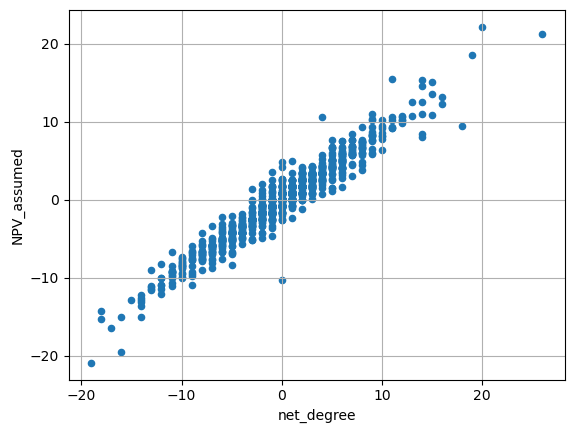

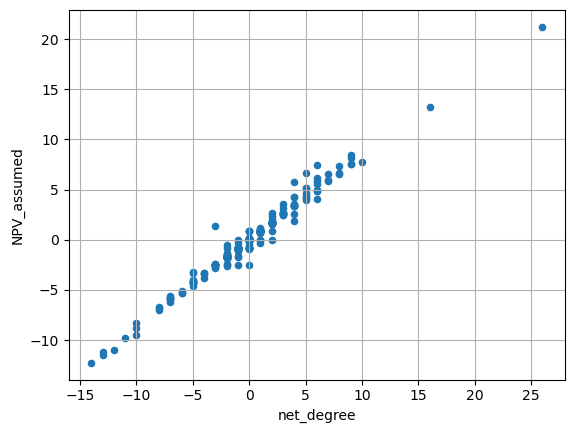

In [20]:
# distributions and summary stats

# ND/NPV SUMMARY STATS
# ---

# ND VS NPV SCATTER

npv_df.plot.scatter(y='NPV_assumed', x='net_degree', grid=True)
filtered = npv_df[npv_df['year'] == 2023]
filtered.plot.scatter(y='NPV_assumed', x='net_degree', grid=True)

# AGG NPV BY SCHOOL

school_summary_npv = npv_df.groupby('school')['NPV_assumed'].sum().reset_index().sort_values('NPV_assumed', ascending=False)
print(school_summary_npv.head(15))
print(school_summary_npv.tail(15))

# AGG TEAM RATINGS BY SCHOOL FOR SAME YEARS

#teamratings_df['year'] = teamratings_df['season'].apply(lambda x: int(x.split('-')[0]))